In [1]:
#import urllib2
from io import StringIO
import os
import xmltodict
import pandas as pd
import geopandas as gpd
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm

from datetime import datetime 
import statsmodels.api as sm
import time

from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import sys
import requests
import glob

from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point

import rasterstats as rs
import rasterio

import requests

from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import show_hist
from shapely.geometry import box
from rasterstats import zonal_stats
from windrose import WindroseAxes
#import pycrs
#import earthpy as et
#import earthpy.plot as ep

from scipy.optimize import curve_fit

from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

import cartopy


#import pymannkendall as mk
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 10

In [2]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)

ucc_key = dbconnect.get_ucc_api()

In [3]:
import geopandas
import contextily as ctx
latitude = 39.014255
longitude = -110.166383
source = 'UCC'
url = f"https://climate.usu.edu/API/api.php/v2/key={ucc_key}/station_search/source={source}/radius=15/lat={latitude}/long={longitude}"
print(url)
resp = requests.get(url)


https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/source=UCC/radius=15/lat=39.014255/long=-110.166383


In [5]:
import json
try:
    response_ob = resp.json()
except:
    response_ob = json.loads(resp.text[resp.text.find('\n\n')+2:])

In [6]:
response_ob 

{'success': True,
 'payload': [{'station_id': '124033',
   'name': 'Green River',
   'latitude': '39.02',
   'longitude': '-110.16',
   'elevation': '4103',
   'state': 'UT',
   'country': 'US',
   'primary_id': '2131',
   'network': 'USCAN',
   'source': 'UCC'},
  {'station_id': '1277538',
   'name': 'Green River',
   'latitude': '39.058968',
   'longitude': '-110.09063',
   'elevation': '4340',
   'state': 'UT',
   'country': 'US',
   'primary_id': '442',
   'network': 'AGWX',
   'source': 'UCC'}]}

  station_id         name   latitude   longitude elevation state country  \
0     124033  Green River      39.02     -110.16      4103    UT      US   
1    1277538  Green River  39.058968  -110.09063      4340    UT      US   

  primary_id network source                           geometry  
0       2131   USCAN    UCC  POINT (-12262955.106 4724536.806)  
1        442    AGWX    UCC  POINT (-12255232.873 4730121.756)  


(-110.26638299999999, -110.066383, 38.914255, 39.114255)

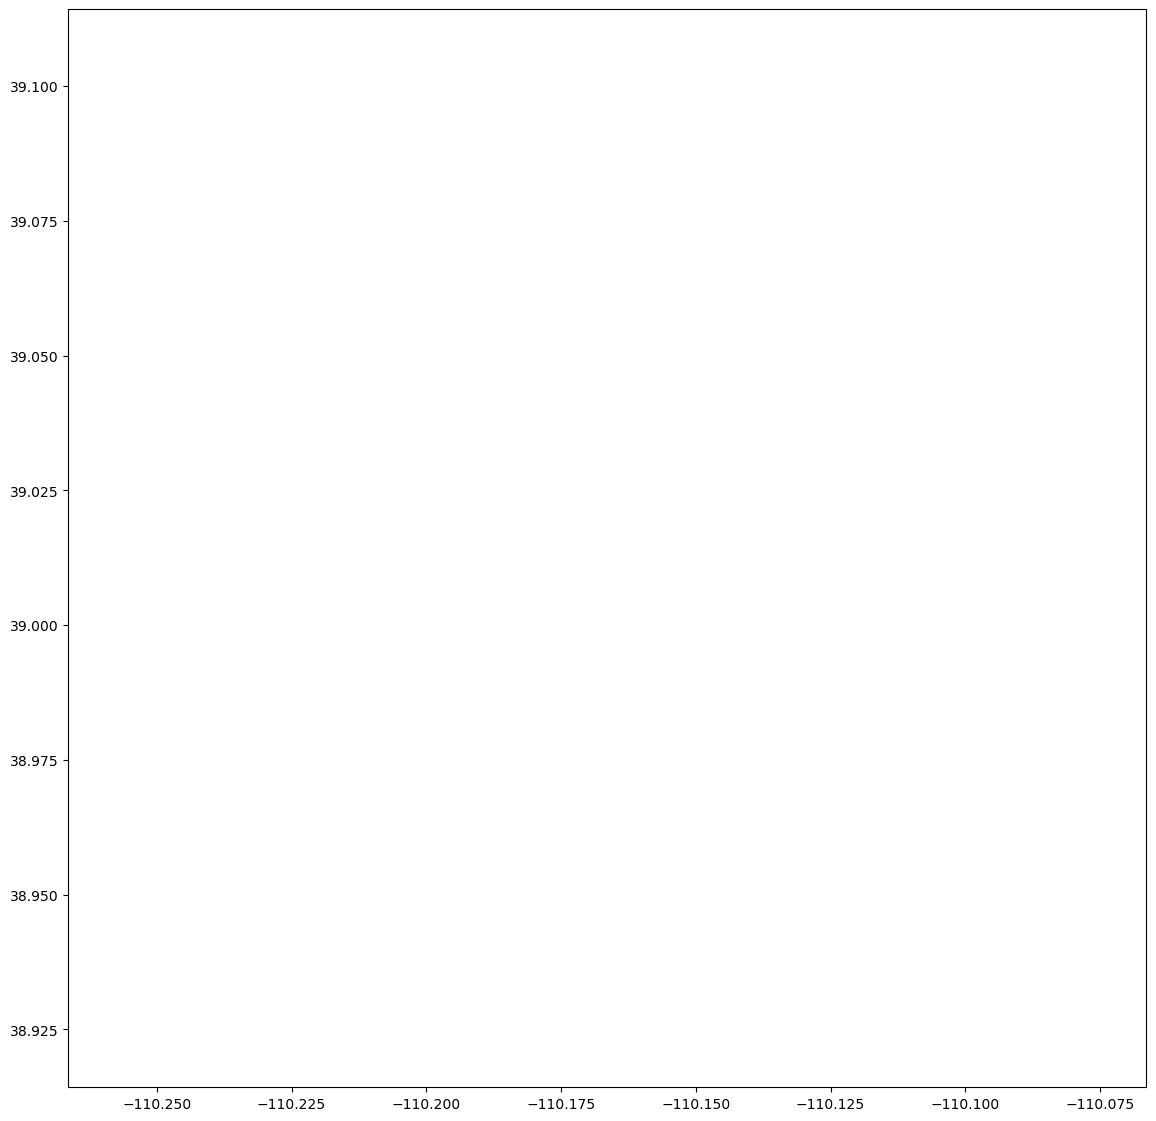

In [7]:
df = pd.DataFrame(response_ob['payload'])
ghcn_stations = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs='EPSG:4269')).to_crs(epsg=3857)
print(ghcn_stations)
ax = ghcn_stations.plot(figsize=(14, 14), column='name',legend=False)
ax.axis((longitude-0.1,longitude+0.1, latitude-0.1, latitude+0.1))
#ctx.add_basemap(ax)

In [ ]:
https://climate.usu.edu/API/api.php/v3/key=/station_search/source=SCAN/state=UT

In [10]:
stations

,name,latitude,longitude,elevation,state,country,primary_id,network,source
station_id,,,,,,,,,
124033,Green River,39.02,-110.16,4103,UT,US,2131,USCAN,UCC
1277538,Green River,39.058968,-110.09063,4340,UT,US,442,AGWX,UCC


In [11]:
stations = df.set_index(['station_id'])

out_format = 'json'
start_date = '2020-10-01T00:00:00'
end_date = '2024-07-12T00:00:00'
freq = 'get_daily' #get_hourly
 
newbegdate = pd.to_datetime(start_date)
newenddate = newbegdate + pd.Timedelta(29*6,'D')

hed = {}
dat = {}

for stat in stations.index.unique():
    if stat == '124033':
        scandat = {}
        source = stations.loc[stat,'network']
        while newbegdate <= datetime.now():
            if freq == 'get_daily':
                begstr = newbegdate.strftime("%Y-%m-%d")
                endstr = newenddate.strftime("%Y-%m-%d")
            else:
                begstr = newbegdate.strftime("%Y-%m-%dT%H:%M:%S")
                endstr = newenddate.strftime("%Y-%m-%dT%H:%M:%S")

            url = f"https://climate.usu.edu/API/api.php/v2/key={ucc_key}/station_search/network={source}/station_id={stat}/{freq}/start_date={begstr}/end_date={endstr}/units=m"
            print(url)
            response_ob = requests.get(url).json()
            newbegdate += pd.Timedelta(29*6,'D')
            newenddate += pd.Timedelta(29*6,'D') 
            scandat[endstr] = pd.DataFrame(response_ob['payload'])

            time.sleep(1)
        dat[stations.loc[stat,"name"]] = pd.concat(scandat)


https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/network=USCAN/station_id=124033/get_daily/start_date=2020-10-01/end_date=2021-03-24/units=m
https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/network=USCAN/station_id=124033/get_daily/start_date=2021-03-24/end_date=2021-09-14/units=m
https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/network=USCAN/station_id=124033/get_daily/start_date=2021-09-14/end_date=2022-03-07/units=m
https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/network=USCAN/station_id=124033/get_daily/start_date=2022-03-07/end_date=2022-08-28/units=m
https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/network=USCAN/station_id=124033/get_daily/start_date=2022-08-28/end_date=2023-02-18/units=m
https://climate.usu.edu/API/api.php/v2/key=myR49SmUMATJtwIlstKqoIJotloOem/station_search/networ

NameError: name 'station' is not defined

In [12]:
stat = '124033'
dat[stations.loc[stat,"name"]] = pd.concat(scandat)

In [38]:
dat[stations.loc[stat,"name"][0]] = pd.concat(scandat)

In [56]:
dat = pd.read_csv("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Data_Downloads/BSF/previous_data/BFLAT.2021-09-14.csv",
                 skiprows=[0,1,2,3,4,5,6,7,8,9,11],index_col='Date_Time')
dat
#winddata = windat.reset_index().rename(columns={'level_0':'filename'}).drop('level_1',axis=1).set_index('filename')

C:\Users\paulinkenbrandt\.conda\envs\pygis39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Station_ID,net_radiation_set_1,pressure_set_1,air_temp_set_1,air_temp_set_2,relative_humidity_set_1,wind_speed_set_1,wind_direction_set_1,wind_gust_set_1,precip_accum_five_minute_set_1,...,surface_level_set_1,outgoing_radiation_sw_set_1,outgoing_radiation_lw_set_1,incoming_radiation_lw_set_1,dew_point_temperature_set_1d,wind_chill_set_1d,wind_cardinal_direction_set_1d,sea_level_pressure_set_1d,heat_index_set_1d,altimeter_set_1d
Date_Time,,,,,,,,,,,,,,,,,,,,,
2016-09-29T19:35:00Z,BFLAT,NaN,87698.0,21.60,NaN,50.64,1.73,37.08,2.61,0.0,...,11.684,163.30,NaN,NaN,10.88,NaN,NE,101576.63,NaN,102376.45
2016-09-29T19:40:00Z,BFLAT,NaN,87694.0,21.48,NaN,50.88,1.69,20.14,2.95,0.0,...,14.224,101.20,NaN,NaN,10.84,NaN,NNE,101577.99,NaN,102371.78
2016-09-29T19:45:00Z,BFLAT,NaN,87686.0,21.45,NaN,51.55,1.74,30.04,2.69,0.0,...,14.224,172.80,NaN,NaN,11.01,NaN,NNE,101570.21,NaN,102362.44
2016-09-29T19:50:00Z,BFLAT,NaN,87680.0,21.76,NaN,52.30,0.86,354.00,1.79,0.0,...,10.414,172.70,NaN,NaN,11.52,NaN,N,101547.75,NaN,102355.43
2016-09-29T19:55:00Z,BFLAT,NaN,87679.0,22.26,NaN,49.09,0.60,24.87,2.00,0.0,...,6.35,169.20,NaN,NaN,11.02,NaN,NNE,101521.75,NaN,102354.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13T23:40:00Z,BFLAT,75.81,87008.0,28.91,NaN,18.56,3.39,168.50,4.33,0.0,...,32.004,153.76,487.77,342.24,2.71,NaN,SSE,100425.11,27.36,101570.96
2021-09-13T23:45:00Z,BFLAT,62.26,87006.0,28.95,NaN,18.49,2.74,168.10,3.82,0.0,...,32.004,146.66,487.13,341.54,2.69,NaN,SSE,100420.92,27.39,101568.62
2021-09-13T23:50:00Z,BFLAT,48.31,87002.0,29.04,NaN,18.56,1.95,136.40,2.73,0.0,...,29.718,140.17,486.79,340.90,2.82,NaN,SE,100412.07,27.46,101563.95


In [56]:
data = dat['Canyonlands Research Center'].reset_index().set_index('date_time').drop(columns=['level_0','level_1'],axis=1).dropna(how='all',
                                                                                                                          subset=['windd_sd', 'airt2_avg', 'battv_min', 'precip_tb','windd_avg', 'winds_avg', 'winds_max'])
data = data[['windd_avg','winds_avg']].dropna()
data['windd_avg'] = pd.to_numeric(data['windd_avg'],errors='coerce')
data['winds_avg'] = pd.to_numeric(data['winds_avg'],errors='coerce')

In [14]:
data = dat[stations.loc[stat,"name"]]

In [18]:
data.dtypes

date_time     object
station_id    object
eto           object
etr           object
airt          object
battv         object
ea_avg        object
rh_max        object
rh_min        object
soilm2        object
soilm4        object
soilm8        object
td_avg        object
soil1t2       object
soil1t4       object
soil1t8       object
soilm20       object
soilm40       object
solarmj       object
airt_avg      object
airt_max      object
airt_min      object
esat_avg      object
soil1t20      object
soil1t40      object
precip_tb     object
timestamp     object
windd_avg     object
winds_avg     object
winds_max     object
dtype: object

[Text(0.0, 0, 'E'),
 Text(0.7853981633974483, 0, 'NE'),
 Text(1.5707963267948966, 0, 'N'),
 Text(2.356194490192345, 0, 'NW'),
 Text(3.141592653589793, 0, 'W'),
 Text(3.9269908169872414, 0, 'SW'),
 Text(4.71238898038469, 0, 'S'),
 Text(5.497787143782138, 0, 'SE')]

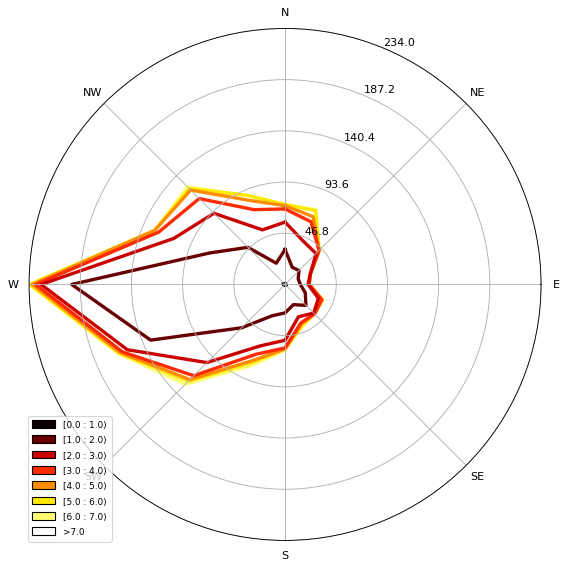

In [19]:
data = data[['windd_avg','winds_avg']].dropna()
data['windd_avg'] = pd.to_numeric(data['windd_avg'],errors='coerce')
data['winds_avg'] = pd.to_numeric(data['winds_avg'],errors='coerce')
ax = WindroseAxes.from_ax()

#wdf = data.rename(columns={'wind_direction_set_1':'direction','wind_speed_set_1':'speed'})
wdf = data.rename(columns={'windd_avg':'direction','winds_avg':'speed'}).dropna()

wdf = wdf[['speed','direction']]
wd = wdf['direction']
ws = wdf['speed']

ax.contour(wd, ws, bins=np.arange(0, 8, 1), cmap=cm.hot, lw=3)
ax.set_legend()

#ax.bar(wd, ws, normed=True, opening=1.0, edgecolor='white')


ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])

#plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/dugout_wind_rose_map.jpg")
#plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/green_river_wind_rose_map.pdf")

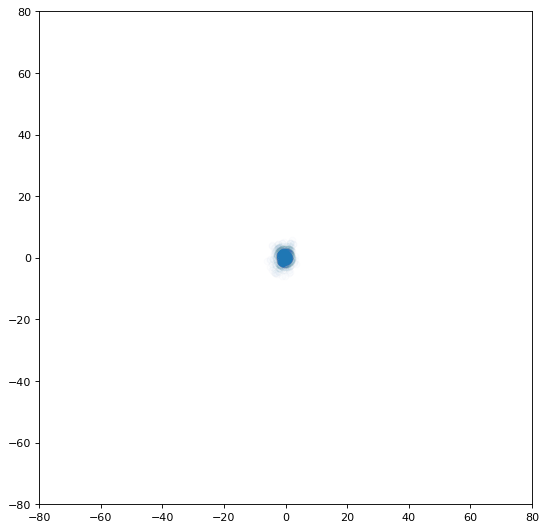

In [20]:

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect('equal')
#_ = ax.scatter(df['speed_x'], df['speed_y'], alpha=0.25)
wdf['speed_x'] = wdf['speed'] * np.sin(wdf['direction'] * np.pi / 180.0)
wdf['speed_y'] = wdf['speed'] * np.cos(wdf['direction'] * np.pi / 180.0)
ax.scatter(wdf['speed_x'], wdf['speed_y'], alpha=0.01)
Vw = 80
_ = ax.set_xlim([-Vw, Vw])
_ = ax.set_ylim([-Vw, Vw])

In [26]:
data = {}
hed = {}
for file in glob.glob("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/Data_Downloads/BSF/previous_data/*.csv"):
    dname = os.path.basename(file)
    hed[dname] = pd.read_csv(file,skiprows=1,nrows=8,names=['ind','desc'],index_col='ind').T
    dat = pd.read_csv(file,skiprows=14,na_values=['S','M'])
    data[dname] = dat.rename(columns={'Wind Direction ':'Wind Direction',
                                     'Surface Wind Speed':'Wind Speed',
                                     'Wind Direction Average':'Wind Direction',
                                     'Wind Speed Average':'Wind Speed'}) 
print(data.keys())
windat = pd.concat(data)
hedat = pd.concat(hed)
winddata = windat.reset_index().rename(columns={'level_0':'filename'}).drop('level_1',axis=1).set_index('filename')
hedat = hedat.reset_index().set_index('level_0')

dict_keys(['UCC_scan_2134_2021_03_29_1617070419.csv', 'UCC_scan_2155_2021_03_29_1617070990.csv'])


In [96]:
dat

,Station_ID,Date_Time,air_temp_set_1,relative_humidity_set_1,Wind Direction,Wind Direction,wind_gust_set_1,solar_radiation_set_1,soil_temp_set_1,soil_temp_set_2,precip_accum_fifteen_minute_set_1,soil_moisture_set_1,dew_point_temperature_set_1d,wind_chill_set_1d,wind_cardinal_direction_set_1d,heat_index_set_1d
0,UCC24,2014-09-25T15:45:00Z,24.33,30.0,1.92,98.0,2.73,0.0,19.78,21.11,0.0,24.0,5.62,NaN,E,NaN
1,UCC24,2014-09-25T16:00:00Z,24.89,30.0,1.56,109.0,2.59,1.0,19.94,21.11,0.0,24.0,6.11,NaN,ESE,NaN
2,UCC24,2014-09-25T16:15:00Z,25.83,28.0,1.38,93.0,2.46,1.0,20.17,21.00,0.0,24.0,5.93,NaN,E,NaN
3,UCC24,2014-09-25T16:30:00Z,26.67,25.0,1.25,69.0,2.23,1.0,20.39,21.11,0.0,24.0,5.03,NaN,ENE,26.05
4,UCC24,2014-09-25T16:45:00Z,27.33,25.0,1.16,120.0,2.10,1.0,20.61,21.11,0.0,24.0,5.60,NaN,ESE,26.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219183,UCC24,2022-07-12T09:00:00Z,22.44,34.0,0.63,115.0,1.30,0.0,26.44,26.78,0.0,7.0,5.76,NaN,ESE,NaN
219184,UCC24,2022-07-12T09:15:00Z,20.56,40.0,0.72,106.0,1.70,0.0,26.39,26.67,0.0,7.0,6.44,NaN,ESE,NaN
219185,UCC24,2022-07-12T09:30:00Z,20.83,38.0,1.21,118.0,1.88,0.0,26.17,26.61,0.0,7.0,5.94,NaN,ESE,NaN
219186,UCC24,2022-07-12T09:45:00Z,19.33,43.0,0.45,118.0,1.34,0.0,26.06,26.56,0.0,7.0,6.37,NaN,ESE,NaN


In [ ]:
    data[statname] = dat.rename(columns={'wind_direction_set_1':'Wind Direction',
                                     'wind_speed_set_1':'Wind Direction'}) 

# MESOWEST Data FILES

In [6]:
data = {}
hed = {}

for file in glob.glob("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/colorado_river/meso/*.csv"):
    dname = os.path.basename(file)
    
    head_df = pd.read_table(file,skiprows=4,nrows=4,sep=":", names=['ind','desc'])

    head_df['ind'] = head_df['ind'].apply(lambda x: x.replace("# ","").strip(),1)
    head_df = head_df.set_index('ind')
    head_df.columns = ['description']
    statname = head_df.loc['STATION','description'].strip()
    hed[statname] = head_df.T
    dat = pd.read_csv(file,skiprows=[0,1,2,3,4,5,6,7,8,9,11],na_values=['S','M'],parse_dates=True)
    dat['Station_ID'] = dat['Station_ID'].apply(lambda x: x.strip(),1)
    data[statname] = dat.set_index(["Station_ID","Date_Time"])

windat = pd.concat(data).droplevel(0)
windat = windat.rename(columns={'wind_direction_set_1':'Wind Direction',
                                     'wind_speed_set_1':'Wind Speed'}) 
hedat = pd.concat(hed)
#winddata = windat.reset_index().rename(columns={'level_0':'filename'}).drop('level_1',axis=1).set_index('filename')
hedat = hedat.reset_index().set_index('level_0')

hedat['Longitude'] = pd.to_numeric(hedat['LONGITUDE'])
hedat['Latitude'] = pd.to_numeric(hedat['LATITUDE'])

C:\Users\Hutto\AppData\Local\Temp\ipykernel_23064\1526874782.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(file,skiprows=[0,1,2,3,4,5,6,7,8,9,11],na_values=['S','M'],parse_dates=True)
C:\Users\Hutto\AppData\Local\Temp\ipykernel_23064\1526874782.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(file,skiprows=[0,1,2,3,4,5,6,7,8,9,11],na_values=['S','M'],parse_dates=True)
C:\Users\Hutto\AppData\Local\Temp\ipykernel_23064\1526874782.py:14: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv(file,skiprows=[0,1,2,3,4,5,6,7,8,9,11],na_values=['S','M'],parse_dates=True)


## UCC FILES

In [67]:
data = {}
hed = {}
for file in glob.glob("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/colorado_river/*.csv"):
    dname = os.path.basename(file)
    hed[dname] = pd.read_csv(file,skiprows=1,nrows=8,names=['ind','desc'],index_col='ind').T
    dat = pd.read_csv(file,skiprows=14,na_values=['S','M'])
    print(hed[dname])
    print(dat.columns)
    data[dname] = dat.rename(columns={'Wind Direction ':'Wind Direction',
                                     'Surface Wind Speed':'Wind Speed',
                                     'Wind Direction Average':'Wind Direction',
                                     'Wind Speed Average':'Wind Speed'}) 
print(data.keys())
windat = pd.concat(data)
hedat = pd.concat(hed)
winddata = windat.reset_index().rename(columns={'level_0':'filename'}).drop('level_1',axis=1).set_index('filename')
hedat = hedat.reset_index().set_index('level_0')

hedat['Longitude'] = pd.to_numeric(hedat['Longitude'])
hedat['Latitude'] = pd.to_numeric(hedat['Latitude'])

ind  Station Network   Station ID          Station Name Latitude  Longitude  \
desc       GHCN:COOP  USC00421163  CANYONLANDS-THE NECK    38.46  -109.8214   

ind  Elevation State Country  
desc  1789.5 m    UT      US  
Index(['Day', 'Precipitation', 'Multi-Day Precipitation', 'Snow Depth',
       'Snow Fall', 'Min Temperature', 'Max Temperature',
       'Ref Evapotranspiration'],
      dtype='object')
ind  Station Network   Station ID       Station Name Latitude  Longitude  \
desc       GHCN:COOP  USC00421240  CASTLE VALLEY 1SE  38.6225  -109.3917   

ind  Elevation State Country  
desc    1495 m    UT      US  
Index(['Day', 'Precipitation', 'Multi-Day Precipitation', 'Snow Depth',
       'Snow Fall', 'Min Temperature', 'Max Temperature',
       'Ref Evapotranspiration'],
      dtype='object')
ind  Station Network   Station ID             Station Name Latitude  \
desc       GHCN:COOP  USC00421168  CANYONLANDS-THE NEEDLES  38.1678   

ind   Longitude Elevation State Country  
desc  -

In [62]:
winddata.loc['UCC_ghcn_USC00421163_2022_07_12_1657649854.csv'].columns

Index(['Day', 'Precipitation', 'Multi-Day Precipitation', 'Snow Depth',
       'Snow Fall', 'Min Temperature', 'Max Temperature',
       'Ref Evapotranspiration', 'Air Temp Avg', 'Air Temp Max',
       'Air Temp Time of Max', 'Air Temp Min', 'Air Temp Time of Min',
       'Solar Total', 'Wind Speed Max', 'Wind Speed Time of Max',
       'Wind Speed Avg', 'Wind Direction Avg', 'Wind Direction Standard Dev',
       'Vapor Pressure Avg', 'Rel. Humidity Max', 'Rel. Humidity Min',
       'Dew Point Avg', 'Dew Point Min', 'Dew Point Max',
       'Dew Point Time of Min', 'Dew Point Time of Max', 'Precip Total',
       'Precip Total 7 Days', 'ETo', 'ETr', 'ETr 7 Days', 'ETo 7 Days',
       'Soil Temp Avg 4"', 'Soil Temp Max 4"', 'Soil Temp Time of Max',
       'Soil Temp Min 4"', 'Soil Temp Time of Min', 'Soil Temp Avg 8"',
       'Soil Moist. Avg 8"', 'Batt Min'],
      dtype='object')

In [29]:
hedat['Longitude'] = pd.to_numeric(hedat['Longitude'])
hedat['Latitude'] = pd.to_numeric(hedat['Latitude'])

In [114]:
windat

air_temp_set_1  relative_humidity_set_1  \
Station_ID Date_Time                                                       
BDGU1      2011-02-01T22:35:00Z           -2.67                      NaN   
           2011-02-01T22:40:00Z           -2.72                      NaN   
           2011-02-01T22:45:00Z           -2.67                      NaN   
           2011-02-01T22:50:00Z           -3.00                      NaN   
           2011-02-01T22:55:00Z           -3.17                      NaN   
...                                         ...                      ...   
UCC24      2022-07-12T09:00:00Z           22.44                     34.0   
           2022-07-12T09:15:00Z           20.56                     40.0   
           2022-07-12T09:30:00Z           20.83                     38.0   
           2022-07-12T09:45:00Z           19.33                     43.0   
           2022-07-12T10:00:00Z           19.72                     41.0   

                                 Wind Direction  Wind Direction  \
Station_ID Date_Time                                              
BDGU1      2011-02-01T22:35:00Z             NaN             NaN   
           2011-02-01T22:40:00Z             NaN             NaN   
           2011-02-01T22:45:00Z             NaN             NaN   
           2011-02-01T22:50:00Z             NaN             NaN   
           2011-02-01T22:55:00Z             NaN             NaN   
...                                         ...             ...   
UCC24      2022-07-12T09:00:00Z            0.63           115.0   
           2022-07-12T09:15:00Z            0.72           106.0   
           2022-07-12T09:30:00Z            1.21           118.0   
           2022-07-12T09:45:00Z            0.45           118.0   
           2022-07-12T10:00:00Z            0.72           108.0   

                                 wind_gust_set_1  \
Station_ID Date_Time                               
BDGU1      2011-02-01T22:35:00Z              NaN   
           2011-02-01T22:40:00Z              NaN   
           2011-02-01T22:45:00Z              NaN   
           2011-02-01T22:50:00Z              NaN   
           2011-02-01T22:55:00Z              NaN   
...                                          ...   
UCC24      2022-07-12T09:00:00Z             1.30   
           2022-07-12T09:15:00Z             1.70   
           2022-07-12T09:30:00Z             1.88   
           2022-07-12T09:45:00Z             1.34   
           2022-07-12T10:00:00Z             1.96   

                                 precip_accum_five_minute_set_1  \
Station_ID Date_Time                                              
BDGU1      2011-02-01T22:35:00Z                             0.0   
           2011-02-01T22:40:00Z                             0.0   
           2011-02-01T22:45:00Z                             0.0   
           2011-02-01T22:50:00Z                             0.0   
           2011-02-01T22:55:00Z                             0.0   
...                                                         ...   
UCC24      2022-07-12T09:00:00Z                             NaN   
           2022-07-12T09:15:00Z                             NaN   
           2022-07-12T09:30:00Z                             NaN   
           2022-07-12T09:45:00Z                             NaN   
           2022-07-12T10:00:00Z                             NaN   

                                 solar_radiation_set_1  \
Station_ID Date_Time                                     
BDGU1      2011-02-01T22:35:00Z                    NaN   
           2011-02-01T22:40:00Z                    NaN   
           2011-02-01T22:45:00Z                    NaN   
           2011-02-01T22:50:00Z                    NaN   
           2011-02-01T22:55:00Z                    NaN   
...                                                ...   
UCC24      2022-07-12T09:00:00Z                    0.0   
           2022-07-12T09:15:00Z                    0.0   
           2022-07-12T09:30:00Z            

# Plot Windrose Map

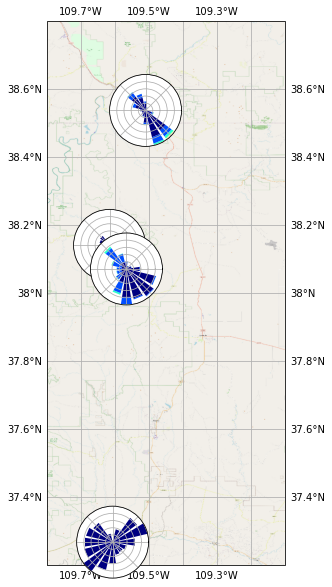

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import windrose


minlon, maxlon, minlat, maxlat = (-109.8, -109.1, 37.2, 38.8)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
# Draw main ax on top of which we will add windroses
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()

request = cimgt.OSM()
main_ax.add_image(request, 12)

# Coordinates of the station we were measuring windspeed
wr = {}
for ind in hedat.index.unique():
    df = windat.loc[ind,['Wind Speed','Wind Direction']].dropna()
    ws = df['Wind Speed']
    wd = df['Wind Direction']

    if len(df)>0:
        wr[ind] = inset_axes(main_ax,
                             width=1,
                             height=1,
                             loc='center',
                             bbox_to_anchor=(hedat.loc[ind,'Longitude'], hedat.loc[ind,'Latitude']), # position of the axe
            bbox_transform=main_ax.transData,    # use data coordinate (not axe coordinate)
            axes_class=windrose.WindroseAxes,    # specify the class of the axe
            )

        wr[ind].bar(wd,ws)
        wr[ind].tick_params(labelleft=False, labelbottom=False)
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/co_wind_rose_map.jpg")
plt.savefig("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/co_wind_rose_map.pdf")

In [7]:
hedat

ind,level_1,STATION,STATION NAME,LATITUDE,LONGITUDE,Longitude,Latitude
level_0,,,,,,,
BDGU1,description,BDGU1,BLANDING 26SSW,37.2667,-109.60740,-109.607400,37.266700
MOAB,description,MOAB,"USGS/NPS Building, Moab",38.537356,-109.510439,-109.510439,38.537356
MTCU1,description,MTCU1,MONTICELLO 24NW,38.14020,-109.61650,-109.616500,38.140200
UCC24,description,UCC24,Canyonlands Research Center,38.07078,-109.56670,-109.566700,38.070780


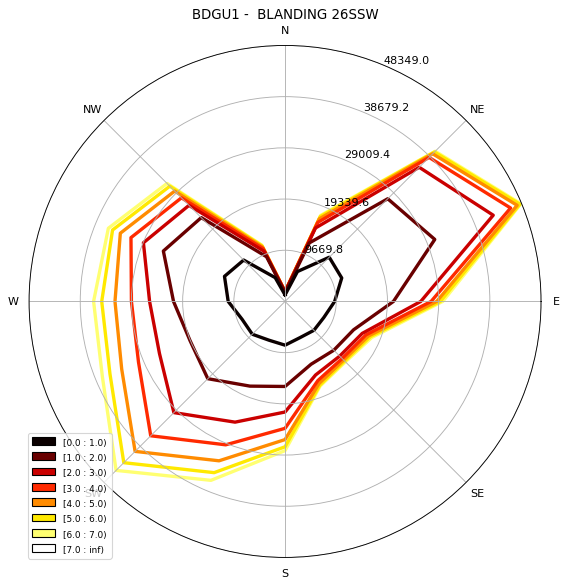

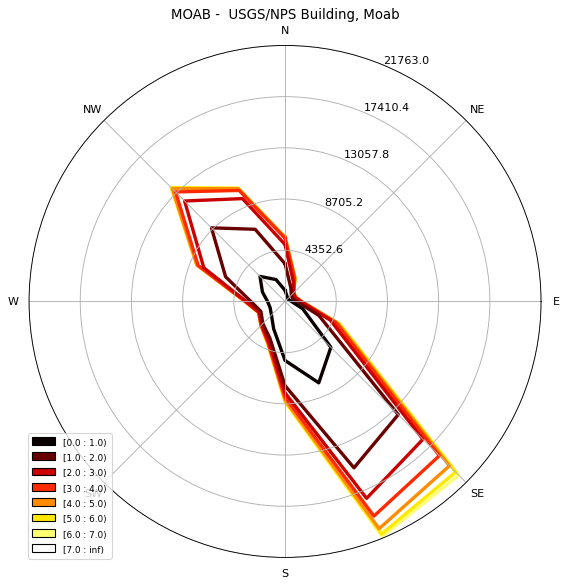

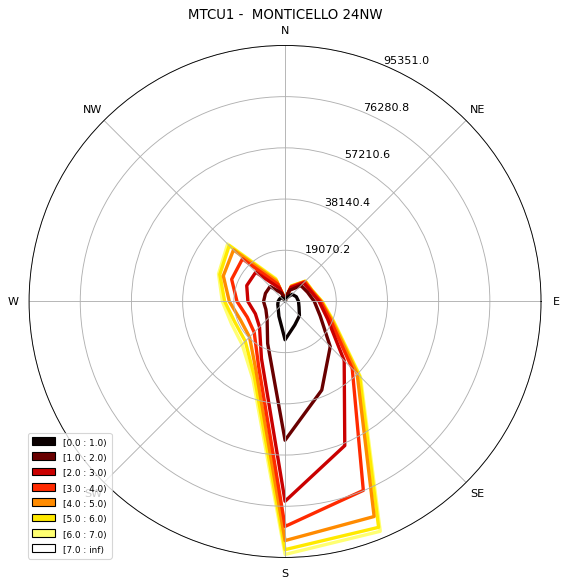

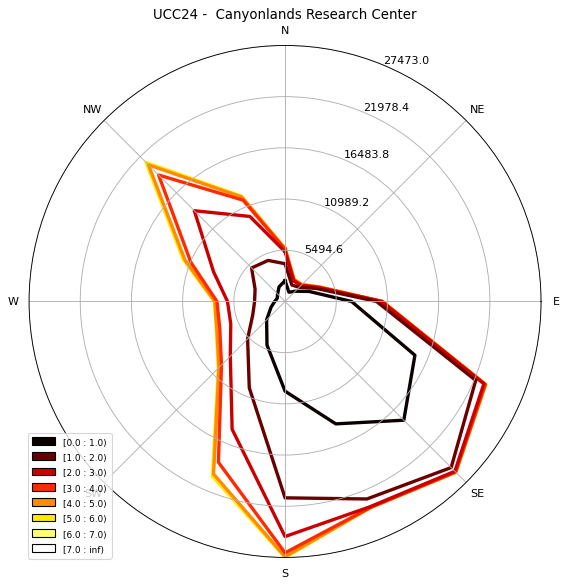

In [9]:
# Coordinates of the station we were measuring windspeed
wr = {}
for ind in hedat.index.unique():
    df = windat.loc[ind,['Wind Speed','Wind Direction']].dropna()
    ws = df['Wind Speed']
    wd = df['Wind Direction']

    ax = WindroseAxes.from_ax()


    ax.contour(wd, ws, bins=np.arange(0, 8, 1), cmap=cm.hot, lw=3)
    ax.set_legend()

    #ax.bar(wd, ws, normed=True, opening=1.0, edgecolor='white')


    ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
    
    plt.title(f"{ind} - {hedat.loc[ind,'STATION NAME']}")
    
    plt.savefig(f"G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/{ind}_wind_rose.jpg")
    plt.savefig(f"G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/climate_data/{ind}_wind_rose.pdf")

In [91]:
hedat.to_csv("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS/Weather_Stations.csv")

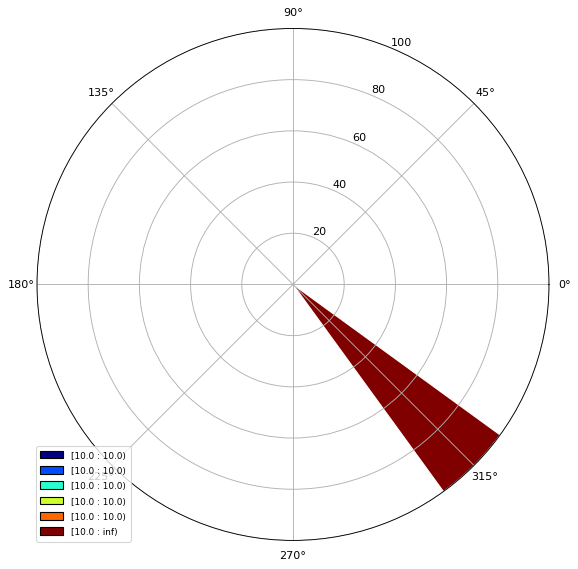

In [87]:
axes = WindroseAxes.from_ax()
axes.bar([140]*100, [10]*100, normed=True, opening=0.8, edgecolor='white')
axes.set_legend()
        

In [ ]:
'UCC_awos_KPUC_2020_11_22_1606082818.csv', []
'UCC_scan_2132_2020_11_22_1606082812.csv', 
'UCC_upr_UR309_2020_11_22_1606082826.csv', 
'UCC_utah_dot_UTPSB_2020_11_22_1606082829.csv', 
'UCC_utah_climate_center_UCL18_2020_11_22_1606082822.csv'

<AxesSubplot:>

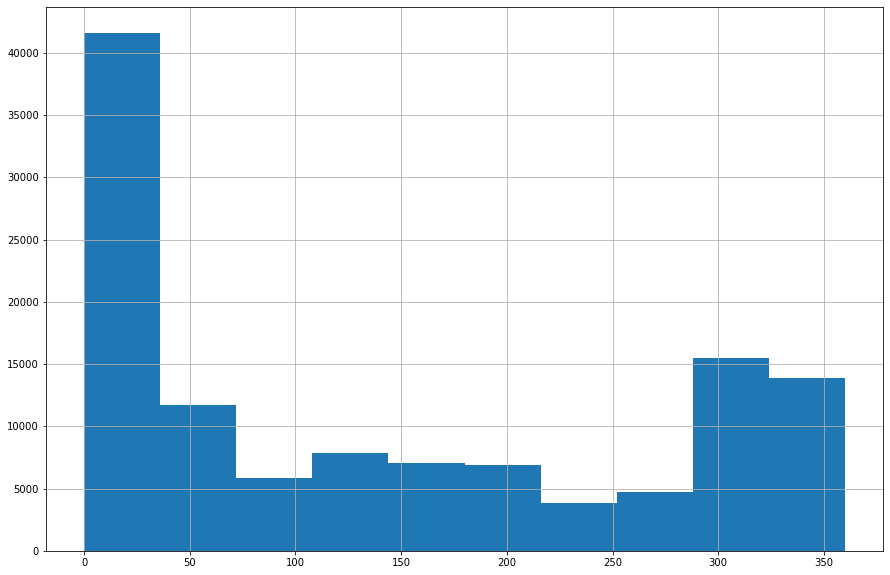

In [16]:
data['UCC_awos_KPUC_2020_11_22_1606082818.csv']['Wind Direction']